In [1]:
import numpy as np
import pandas as pd
import warnings
import codecs
import os

import aut_vinc_bballCrawler as bc

## Get 2017 data

In [2]:
pergame = bc.getSoupFromURL('http://www.basketball-reference.com/leagues/NBA_2017_per_game.html')
pg = pergame.findAll('table')
header = []
for th in pg[0].findAll('th'):
    if not th.getText() in header:
        header.append(th.getText())
rows = pg[0].findAll('tr')[1:]  # all rows but the header
rows = [r for r in rows if len(r.findAll('td')) > 0]
parsed_table = [[col.getText() for col in row.findAll('td')] for row in rows]
ptable = pd.io.parsers.TextParser(parsed_table, names=header[1:30], index_col=0).get_chunk()
# invert the turnover metric
ptable.TOV = 1/ptable.TOV
ptable.TOV[np.isinf(ptable.TOV)] = ptable.TOV[~np.isinf(ptable.TOV)].mean()
ptable.replace(np.nan, 0, inplace=True)
feature_vec = ['FG%','FT%','3P','TRB','AST','STL','BLK','TOV','PS/G']

bt = pd.read_excel('autvinc_table.xlsx')
bt.tov = (1/bt.tov)*(10**3)
bt.describe()

/Users/andric/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,wk,season,fg.,ft.,X3p,trb,ast,stl,blk,tov,pts
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,8.826087,1.782609,0.456854,0.773863,45.617391,241.591304,134.600000,42.645652,27.430435,12.732987,619.800000
std,5.282042,0.750107,0.023615,0.047178,13.864318,38.307982,23.969861,9.151978,8.888902,2.372693,88.323351
min,1.000000,1.000000,0.381200,0.611900,14.000000,132.000000,73.000000,19.000000,7.000000,8.264463,363.000000
25%,4.000000,1.000000,0.440650,0.743500,35.000000,213.750000,118.000000,37.000000,21.000000,11.111111,563.000000
50%,8.000000,2.000000,0.456550,0.778600,45.000000,239.000000,133.500000,42.000000,27.000000,12.345679,621.000000
75%,13.000000,2.000000,0.474700,0.808650,54.000000,268.250000,150.250000,48.000000,33.000000,13.888889,672.250000
max,19.000000,3.000000,0.520700,0.882000,90.000000,355.000000,205.000000,78.000000,64.000000,23.809524,920.000000


In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [365]:
X = np.array(bt.iloc[:,3:])
ss = StandardScaler()
ssX = ss.fit_transform(X)
labels = []
for i in range(0, X.shape[0], 2):
    if len(np.where((X[i, :] - X[i+1,:]) > 0)[0]) > 5:
        labels.append('win')
        labels.append('loss')
    else:
        labels.append('loss')
        labels.append('win')

le = LabelEncoder()
y = le.fit_transform(np.array(labels))
X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.2)

In [366]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = feature_vec
forest = RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy')
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

  1) PS/G                           0.149025
  2) FG%                            0.143269
  3) AST                            0.119247
  4) FT%                            0.105739
  5) 3P                             0.103758
  6) TRB                            0.102737
  7) BLK                            0.098798
  8) STL                            0.090016
  9) TOV                            0.087411


In [297]:
from sklearn.metrics import accuracy_score

In [367]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))

Train/test accuracies: 0.997/0.620


## SVC and tuning

In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

In [368]:
pipe_svc = Pipeline([('pca', PCA()),
                     ('clf', SVC(probability=True))])

param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'pca__n_components': [3, 4, 5],
               'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'pca__n_components': [3, 4, 5],
               'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print(gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

{'clf__C': 0.01, 'pca__n_components': 3, 'clf__kernel': 'linear'}
Pipeline(steps=[('pca', PCA(copy=True, n_components=3, whiten=False)), ('clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Best score: 0.655
CV accuracy 0.676 +/- 0.113


In [369]:
svc = SVC(probability=True)

param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'C': param_range,
               'kernel': ['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print(gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

{'C': 0.01, 'kernel': 'linear'}
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best score: 0.652
CV accuracy 0.676 +/- 0.123


In [370]:
svc = SVC(C=10, gamma=.001, kernel='rbf', probability=True)
svc.fit(X_train, y_train)
svcscores = cross_val_score(svc, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('SVC acc: %.3f +/- %.3f' % (np.mean(svcscores), np.std(svcscores)))

SVC acc: 0.663 +/- 0.124


## Get league rosters

In [312]:
import espn_fantasy_scrape
rosters = espn_fantasy_scrape.return_rosters()

mysquad = rosters["delonte\'s donuts"]
for nom in mysquad:
    if nom == 'Otto Porter Jr.':
        mysquad.remove(nom)
        mysquad.append('Otto Porter')

ser_plyr = []
fr_plyr = []
my_plyr_inds = []
for player in mysquad:
    if type(ptable.loc[player, feature_vec]) is pd.Series:
        ser_plyr.append(player)
        my_plyr_inds.append(ptable.index.get_loc(player))
    if type(ptable.loc[player, feature_vec]) is pd.DataFrame:
        fr_plyr.append(player)
        my_plyr_inds.append(np.where(ptable.index.get_loc(player) == True)[0][0])
mysqd_table = ptable.loc[ser_plyr, feature_vec]
for fplayer in fr_plyr:
    mysqd_table = mysqd_table.append(ptable.loc[fplayer, feature_vec].iloc[0, ])
mysqd_table = mysqd_table.reset_index()

mysqd_vec = mysqd_table.loc[:, feature_vec].mean(0)
mysqd_table

username: ········
password: ········


,Player,FG%,FT%,3P,TRB,AST,STL,BLK,TOV,PS/G
0,Kemba Walker,0.454,0.806,2.6,3.9,5.5,1.4,0.2,0.454545,22.3
1,Gary Harris,0.481,0.688,1.2,3.0,2.7,0.8,0.3,1.111111,12.5
2,Giannis Antetokounmpo,0.526,0.789,0.7,9.1,5.8,2.0,1.9,0.333333,23.4
3,Joel Embiid,0.468,0.765,1.2,7.4,1.7,0.7,2.4,0.270270,18.7
4,Brandon Knight,0.394,0.850,1.0,2.8,2.7,0.6,0.0,0.500000,13.3
5,Kevin Durant,0.538,0.870,1.9,8.6,4.5,1.2,1.5,0.476190,26.2
6,Myles Turner,0.530,0.794,0.6,7.3,1.0,0.7,2.4,0.714286,15.3
7,Patty Mills,0.482,0.929,2.1,1.9,3.6,0.9,0.0,0.714286,11.1
8,Rudy Gobert,0.698,0.678,0.0,11.9,0.9,0.6,2.6,0.625000,12.5
9,Josh Richardson,0.373,0.750,1.6,3.1,2.2,0.7,0.4,0.769231,10.1


In [371]:
ss_ptable = ss.fit_transform(ptable.loc[:, feature_vec])
print('SVC prediction: %d' % gsfit.predict(ss_ptable[my_plyr_inds, :].mean(0)[np.newaxis, :]))
l, w = gsfit.predict_proba(ss_ptable[my_plyr_inds, :].mean(0)[np.newaxis, :])[0]
print('SVC predict win: %.4f, loss: %.4f' % (w, l))

SVC prediction: 1
SVC predict win: 0.7773, loss: 0.2227


In [13]:
def roster_indices(squad, ptable):
    """Give roster and get player indices.
    
    Example input arg:
        squad: rosters["sami\'s mannschaft"]
        ptable: player table from basketball-reference.com
    """
    plyr_inds = []
    for player in squad:
        if player == 'Otto Porter Jr.':
            player = 'Otto Porter'
        if player == 'Louis Williams':
            player = 'Lou Williams'
        if player == 'TJ Warren':
            player = 'T.J. Warren'
        if player == 'Ben Simmons':
            continue
        if type(ptable.loc[player, feature_vec]) is pd.Series:
            plyr_inds.append(ptable.index.get_loc(player))
        if type(ptable.loc[player, feature_vec]) is pd.DataFrame:
            plyr_inds.append(np.where(ptable.index.get_loc(player) == True)[0][0])

    return plyr_inds

In [14]:
list(rosters.keys())

['conquest pain',
 "conor's turpentines",
 'no look no pass',
 'what the blood clot',
 'ian banh mahinmi',
 "sami's mannschaft",
 "delonte's donuts",
 'accidental twitter hog',
 'paul george, john and ...',
 'soccer karate']

In [372]:
winpct = {}
for ros in rosters:
    indxs = roster_indices(rosters[ros], ptable)
    l, w = gsfit.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    winpct[ros] = w
    print('%s SVC predict win: %.4f, loss: %.4f' % (ros, w, l))

conquest pain SVC predict win: 0.7066, loss: 0.2934
conor's turpentines SVC predict win: 0.7476, loss: 0.2524
no look no pass SVC predict win: 0.7217, loss: 0.2783
what the blood clot SVC predict win: 0.7200, loss: 0.2800
ian banh mahinmi SVC predict win: 0.7074, loss: 0.2926
sami's mannschaft SVC predict win: 0.7264, loss: 0.2736
delonte's donuts SVC predict win: 0.7773, loss: 0.2227
accidental twitter hog SVC predict win: 0.7163, loss: 0.2837
paul george, john and ... SVC predict win: 0.6937, loss: 0.3063
soccer karate SVC predict win: 0.7186, loss: 0.2814


In [373]:
import operator
winpct = {}
for ros in rosters:
    indxs = roster_indices(rosters[ros], ptable)
    l, w = svc.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    winpct[ros] = w
    #print('%s SVC predict win: %.4f, loss: %.4f' % (ros, w, l))

srtd_winpct = sorted(winpct.items(), key=operator.itemgetter(1), reverse=True)
for tm in srtd_winpct:
    print('%s SVC predict win: %.4f' % (tm[0], tm[1]))

delonte's donuts SVC predict win: 0.7742
conor's turpentines SVC predict win: 0.7393
no look no pass SVC predict win: 0.7175
sami's mannschaft SVC predict win: 0.7164
soccer karate SVC predict win: 0.7093
accidental twitter hog SVC predict win: 0.7062
what the blood clot SVC predict win: 0.7056
conquest pain SVC predict win: 0.6999
ian banh mahinmi SVC predict win: 0.6978
paul george, john and ... SVC predict win: 0.6842


## Predicted standings

In [134]:
import operator
srtd_winpct = sorted(winpct.items(), key=operator.itemgetter(1), reverse=True)
for tm in srtd_winpct:
    print('%s SVC predict win: %.4f' % (tm[0], tm[1]))

delonte's donuts SVC predict win: 0.7797
conor's turpentines SVC predict win: 0.7411
soccer karate SVC predict win: 0.7243
no look no pass SVC predict win: 0.7151
accidental twitter hog SVC predict win: 0.7096
sami's mannschaft SVC predict win: 0.7081
ian banh mahinmi SVC predict win: 0.7062
what the blood clot SVC predict win: 0.7054
conquest pain SVC predict win: 0.7017
paul george, john and ... SVC predict win: 0.6836


## logistic regression

In [201]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score


pipe_lr = Pipeline([('pca', PCA()),
                   ('clf', LogisticRegression())])
pipe_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))
scores = cross_val_score(estimator=pipe_lr, X=ssX, y=y, cv=5, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test accuracy: 0.609
CV accuracy 0.657 +/- 0.052


In [287]:
lr = LogisticRegression()
#lr.fit(X_train, y_train)
scores = cross_val_score(estimator=lr, X=ssX, y=y, cv=10, n_jobs=-1)
print('logistic regression accuracy: %.3f +/- %.3f' % (scores.mean(), scores.std()))

logistic regression accuracy: 0.646 +/- 0.052


In [288]:
lr.fit(X_train, y_train)
acc_score = accuracy_score(y_test, lr.predict(X_test))
print('Accuracy: %.3f' % (acc_score))

Accuracy: 0.652


## Gradient boosting classifier

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

In [301]:
gbe = GradientBoostingClassifier(n_estimators=25, random_state=0)
gbefit = gbe.fit(X_train, y_train)
scores = cross_val_score(gbefit, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
importances = gbefit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

CV accuracy 0.598 +/- 0.133
  1) FG%                            0.159918
  2) PS/G                           0.158807
  3) AST                            0.150893
  4) 3P                             0.112352
  5) TRB                            0.108792
  6) BLK                            0.104333
  7) FT%                            0.091542
  8) TOV                            0.081418
  9) STL                            0.031945


In [302]:
param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'learning_rate': [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2],
               'n_estimators': [10, 20, 30, 40, 50],
               'max_depth': [2, 3, 4, 5, 6, 10]}]
gbe = GradientBoostingClassifier(random_state=0)
gs = GridSearchCV(estimator=gbe,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print(gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

{'max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 50}
GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
Best score: 0.626
CV accuracy 0.603 +/- 0.199


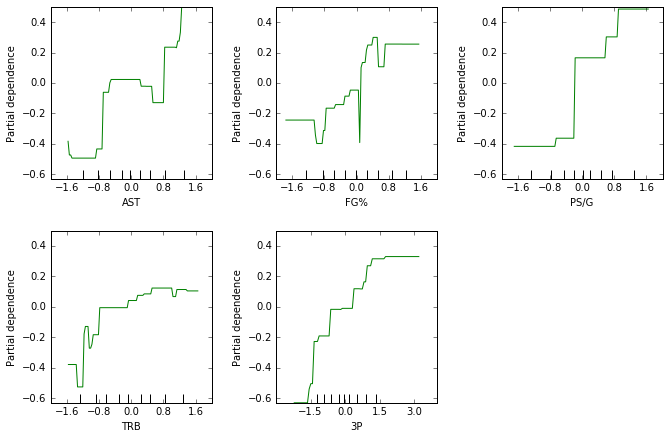

In [214]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plot_partial_dependence(gbefit, X_train,
                                   indices[:5], feature_names=feature_vec, figsize=(10, 10))

In [311]:
import operator
winpct = {}
for ros in rosters:
    indxs = roster_indices(rosters[ros], ptable)
    l, w = gbefit.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    svcl, svcw = svc.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    logl, logw = lr.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    winpct[ros] = np.mean((w, svcw, logw))
    #print('%s SVC predict win: %.4f, loss: %.4f' % (ros, w, l))

srtd_winpct = sorted(winpct.items(), key=operator.itemgetter(1), reverse=True)
for tm in srtd_winpct:
    print('%s predict win: %.4f' % (tm[0], tm[1]))

delonte's donuts predict win: 0.8227
conor's turpentines predict win: 0.7683
no look no pass predict win: 0.7608
accidental twitter hog predict win: 0.7501
soccer karate predict win: 0.7495
ian banh mahinmi predict win: 0.7453
conquest pain predict win: 0.7435
sami's mannschaft predict win: 0.7388
paul george, john and ... predict win: 0.7345
what the blood clot predict win: 0.7235


{'accidental twitter hog': 0.83911766427763013,
 "conor's turpentines": 0.84702650962364867,
 'conquest pain': 0.81041781215166298,
 "delonte's donuts": 0.85274816939088705,
 'ian banh mahinmi': 0.8367356612451694,
 'no look no pass': 0.83191510383616096,
 'paul george, john and ...': 0.79178039568211711,
 "sami's mannschaft": 0.77539474394912633,
 'soccer karate': 0.79693402627361631,
 'what the blood clot': 0.73703501564424789}